# Klasifikasi Tanaman Herbal

In [38]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
import os
import tensorflow_hub as hub

Gunakan pre-trained model mobilenetv2

In [2]:
image_size = (224, 224)
mobilenet_v2 = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

feature_extractor = hub.KerasLayer(mobilenet_v2,
                                   input_shape=image_size + (3,),
                                   trainable=False)

Mount google drive untuk mendapatkan dataset

In [3]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


Copy dataset dari google drive ke google colab environment

In [4]:
import shutil

drive_folder_path = '/content/drive/MyDrive/Dataset klasifikasi tanaman herbal'

colab_folder_path = '/content/Dataset klasifikasi tanaman herbal'

shutil.copytree(drive_folder_path, colab_folder_path)

'/content/Dataset klasifikasi tanaman herbal'

# Pre-processing image

Cek total keseluruhan dataset pada folder training dan validation

In [5]:
training_dir = '/content/Dataset klasifikasi tanaman herbal/Train/'
validation_dir = '/content/Dataset klasifikasi tanaman herbal/Val/'

for folder in os.listdir(training_dir):
    item_path = os.path.join(training_dir, folder)

    print(f'Total foto training {folder}: {len(os.listdir(item_path))}')

print('\n')

for folder in os.listdir(validation_dir):
    item_path = os.path.join(validation_dir, folder)

    print(f'Total foto validasi {folder}: {len(os.listdir(item_path))}')

Total foto training jahe: 241
Total foto training daun sirih: 241
Total foto training daun kelor: 241
Total foto training lidah buaya: 242


Total foto validasi jahe: 41
Total foto validasi daun sirih: 41
Total foto validasi daun kelor: 41
Total foto validasi lidah buaya: 41


Cek sampel foto tiap kategori

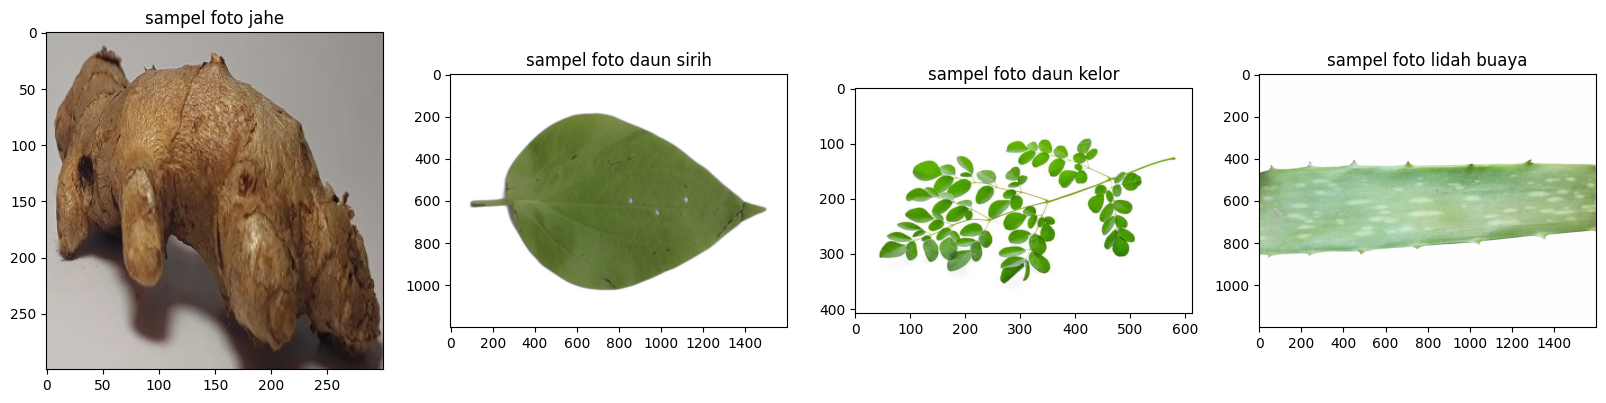

In [6]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 4, figsize=(4 * 5, 5))
for i, folder in enumerate(os.listdir(training_dir)):
    item_path = os.path.join(training_dir, folder)
    sample_image = load_img(f'{os.path.join(item_path, os.listdir(item_path)[0])}')
    axs[i].imshow(sample_image)
    axs[i].set_title(f'sampel foto {folder}')
plt.show()

Cek pixel shape dari setiap foto

In [7]:
for folder in os.listdir(training_dir):
    item_path = os.path.join(training_dir, folder)
    sample_image = load_img(f'{os.path.join(item_path, os.listdir(item_path)[0])}')
    sample_array = img_to_array(sample_image)
    print(f'Setiap foto {folder} memiliki pixel : {sample_array.shape}')

Setiap foto jahe memiliki pixel : (300, 300, 3)
Setiap foto daun sirih memiliki pixel : (1200, 1600, 3)
Setiap foto daun kelor memiliki pixel : (408, 612, 3)
Setiap foto lidah buaya memiliki pixel : (1200, 1600, 3)


Memberikan pelabelan berdasarkan nama folder menggunakan ImageDataGenerator(), sekaligus menormalisasikan dan augmentasi dataset training

In [8]:
def train_val_generators(train_dir, val_dir):
  train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                                     rotation_range=30,
                                     width_shift_range=0.3,
                                     height_shift_range=0.2,
                                     shear_range=0.3,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     fill_mode='nearest')

  train_generator = train_datagen.flow_from_directory(directory=train_dir,
                                                      batch_size=64,
                                                      class_mode='categorical',
                                                      shuffle=True,
                                                      target_size=image_size)

  val_datagen = ImageDataGenerator(rescale=1.0/255.0)

  val_generator = val_datagen.flow_from_directory(directory=val_dir,
                                                  batch_size=32,
                                                  class_mode='categorical',
                                                  target_size=image_size)

  return train_generator, val_generator

train_generator, val_generator = train_val_generators(training_dir, validation_dir)

Found 965 images belonging to 4 classes.
Found 164 images belonging to 4 classes.


# Building Model

Mendefine arsitektur model

In [10]:
def create_model():

  model = tf.keras.models.Sequential([
      feature_extractor,
      layers.Dense(128, activation='relu'),
      layers.Dense(4, activation='softmax')
  ])

  model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
                loss = 'categorical_crossentropy',
                metrics = ['accuracy'])
  return model

Melihat ringkasan arsitektur model

In [11]:
model = create_model()

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                                 
Total params: 2422468 (9.24 MB)
Trainable params: 164484 (642.52 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [12]:
filepath = 'my_model.h5'

checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath,
                    monitor="val_loss", mode="min",
                    save_best_only=True, verbose=1)

Training model

In [13]:
model.fit(train_generator,
          epochs = 15,
          verbose = 2,
          validation_data = val_generator,
          callbacks=[checkpoint])

Epoch 1/15

Epoch 1: val_loss improved from inf to 0.00835, saving model to my_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


16/16 - 135s - loss: 0.2424 - accuracy: 0.9212 - val_loss: 0.0084 - val_accuracy: 1.0000 - 135s/epoch - 8s/step
Epoch 2/15

Epoch 2: val_loss improved from 0.00835 to 0.00343, saving model to my_model.h5
16/16 - 125s - loss: 0.0100 - accuracy: 0.9969 - val_loss: 0.0034 - val_accuracy: 1.0000 - 125s/epoch - 8s/step
Epoch 3/15

Epoch 3: val_loss improved from 0.00343 to 0.00180, saving model to my_model.h5
16/16 - 113s - loss: 0.0047 - accuracy: 0.9979 - val_loss: 0.0018 - val_accuracy: 1.0000 - 113s/epoch - 7s/step
Epoch 4/15

Epoch 4: val_loss did not improve from 0.00180
16/16 - 109s - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.0024 - val_accuracy: 1.0000 - 109s/epoch - 7s/step
Epoch 5/15

Epoch 5: val_loss improved from 0.00180 to 0.00116, saving model to my_model.h5
16/16 - 106s - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.0012 - val_accuracy: 1.0000 - 106s/epoch - 7s/step
Epoch 6/15

Epoch 6: val_loss did not improve from 0.00116
16/16 - 109s - loss: 0.0012 - accuracy: 1.0000

# Evaluate model

Plotting loss, val_loss dan acc, val_acc

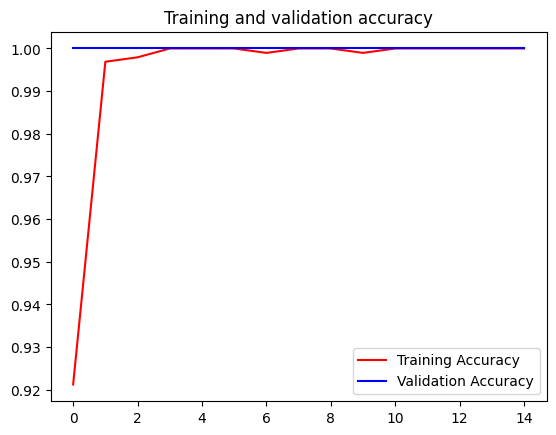

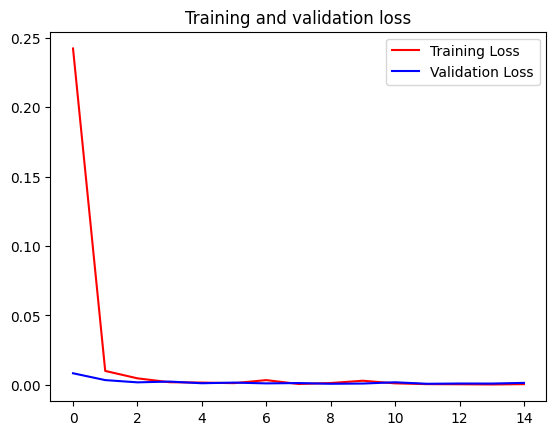

In [14]:
acc=model.history.history['accuracy']
val_acc=model.history.history['val_accuracy']
loss=model.history.history['loss']
val_loss=model.history.history['val_loss']

epochs=range(len(acc))

plt.plot(epochs, acc, 'r', label = "Training Accuracy")
plt.plot(epochs, val_acc, 'b', label = "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.legend()

plt.show()
print('')

plt.plot(epochs, loss, 'r', label = "Training Loss")
plt.plot(epochs, val_loss, 'b', label = "Validation Loss")
plt.title('Training and validation loss')
plt.legend()

plt.show()

Memberikan pelabelan dataset test berdasarkan nama folder menggunakan ImageDataGenerator()

In [15]:
test_dir = '/content/Dataset klasifikasi tanaman herbal/Test/'

test_datagen = ImageDataGenerator(rescale=1.0/255.0)

test_generator = test_datagen.flow_from_directory(directory=test_dir,
                                                  batch_size=32,
                                                  class_mode='categorical',
                                                  target_size=image_size)

Found 164 images belonging to 4 classes.


Evaluasi model menggunakan dataset testing

In [16]:
model.evaluate(test_generator)

6/6 [==============================] - 11s 2s/step - loss: 0.0096 - accuracy: 0.9939


[0.009615400806069374, 0.9939024448394775]

Melakukan prediksi menggunakan foto yang diupload

Saving news_51974_1452140841.jpg to news_51974_1452140841 (4).jpg
1/1 [==============================] - 0s 49ms/step


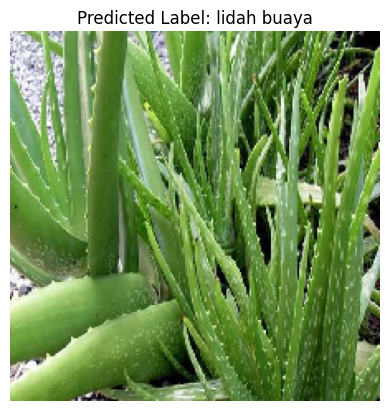

In [46]:
from google.colab import files
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

uploaded = files.upload()

for fn in uploaded.keys():

  path = fn
  image = image.load_img(path, target_size=image_size)
  img = img_to_array(image)
  img = np.expand_dims(img, axis=0)
  img = preprocess_input(img)

  predictions = model.predict(img)
  predicted_class_index = np.argmax(predictions)

  class_indices = train_generator.class_indices
  labels = list(class_indices.keys())
  predicted_class_label = labels[predicted_class_index]

  plt.imshow(image)

  plt.axis('off')
  plt.title(f'Predicted Label: {predicted_class_label}')

  plt.show()

# Save Model

In [24]:
new_model = tf.keras.models.load_model(filepath=filepath,
                                      custom_objects={'KerasLayer':hub.KerasLayer})

converter = tf.lite.TFLiteConverter.from_keras_model(new_model)
tflite_model = converter.convert()
tflite_model_path = './model.tflite'

with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

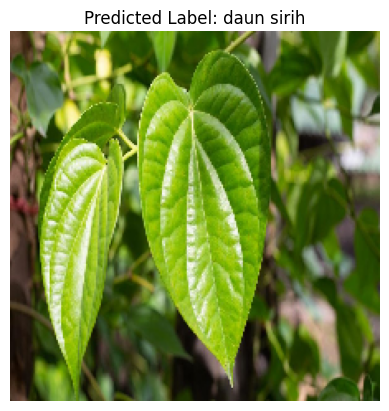

In [44]:
interpreter = tf.lite.Interpreter(model_path='./model.tflite')
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

image_path = './daun-sirih_169.jpeg'

image = image.load_img(image_path, target_size=image_size)
img = img_to_array(image)
img = np.expand_dims(img, axis=0)
img = preprocess_input(img)

interpreter.set_tensor(input_details[0]['index'], img)

interpreter.invoke()

output_data = interpreter.get_tensor(output_details[0]['index'])

label_path = './label.txt'
with open(label_path, 'r') as f:
    labels = f.read().splitlines()

predicted_label_index = np.argmax(output_data)
predicted_label = labels[predicted_label_index]

plt.imshow(image)
plt.axis('off')

plt.title(f'Predicted Label: {predicted_label}')

plt.show()